## Benchmark for measuring performance of engineered features and models

Prepare data for later analysis

In [1]:
import sys
sys.path.insert(0, '../../bosch_helper')
from bosch_helper import *

from sklearn.preprocessing import LabelEncoder
import h5py

%matplotlib inline

### Reload data

In [2]:
x = pd.read_hdf('benchmark_8_numeric_features_1.hdf', 'x')

### Hash value of all numeric rows and `LabelEncode` hash values

In [102]:
if os.path.exists('benchmark_8_numeric_features_2.hdf'):
    hash_numeric = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'hash_numeric')
else:
    hash_numeric = [x.iloc[(n-1)*10**5:n*10**5,:-5].apply(lambda u: hash(tuple(u)), axis=1) for n in range(25)]
    hash_numeric = pd.concat(hash_numeric)
    hash_numeric = pd.Series(hash_numeric)
    hash_numeric.name = 'hash_numeric'

    le = LabelEncoder()
    le_results = le.fit_transform(hash_numeric)
    hash_numeric = pd.DataFrame(hash_numeric)
    hash_numeric['hash_encoded'] = le_results

    hash_numeric.drop(['hash_numeric'], axis=1, inplace=True)

    hash_value_counts = hash_numeric['hash_encoded'].value_counts()

    hash_numeric['count_hash'] = hash_numeric['hash_encoded'].map(hash_value_counts)

    # hash_numeric.to_csv('hash_numeric.csv.gz', compression='gzip')

    hash_numeric.to_hdf('benchmark_8_numeric_features_2.hdf', 'hash_numeric', complib='blosc:lz4', complevel=9)

### Unique value and vlaue counts of each column

In [17]:
column_numeric = x.columns[:-5]

#### Nubmer of unique values for each column

#### Value counts of each column

In [19]:
unique_counts = {c: x.loc[:, c].value_counts() for c in column_numeric}

Plot one example

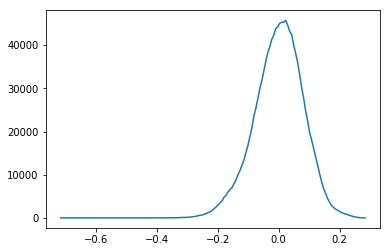

In [20]:
plt.plot(unique_counts['L0_S0_F0'].sort_index().index, unique_counts['L0_S0_F0'].sort_index().values)

### Z-scaled features for each column

##### Directly calculating Z-score has memory error, I will not continue with it to speed up my progress.

### Z-scale for each week

In [19]:
x.drop(['week_number'],axis=1,inplace=True)

In [20]:
count_per_time_unit = x.groupby('time_start')['time_start'].count()
count_per_time_unit = pd.DataFrame(count_per_time_unit)
# count_per_time_unit['mod1680'] = np.mod(count_per_time_unit.index, 1680)
count_per_time_unit['week_number'] = np.around(count_per_time_unit.index/1680, 0)
count_per_time_unit.drop(['time_start'], axis=1, inplace=True)

x = x.join(count_per_time_unit, on='time_start')
x_zscore_per_week = x.groupby('week_number').transform(lambda u: (u-u.mean())/u.std())
x_zscore_per_week.drop(['Response', 'station_start', 'station_end', 'time_start', 'time_end'], axis=1, inplace=True)

x_zscore_per_week.to_hdf('benchmark_8_numeric_features_2.hdf', 'zscore_per_week', complib='blosc:lz4', complevel=9)

In [21]:
x_zscore_per_week = pd.read_hdf('benchmark_8_numeric_features_2.hdf', 'zscore_per_week')

### Count encoding of each value

In [22]:
del x_zscore_per_week
gc.collect()

136

In [24]:
x.columns

Index(['L0_S0_F0', 'L0_S0_F10', 'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16',
       'L0_S0_F18', 'L0_S0_F2', 'L0_S0_F20', 'L0_S0_F22', 'L0_S0_F4',
       ...
       'L3_S51_F4256', 'L3_S51_F4258', 'L3_S51_F4260', 'L3_S51_F4262',
       'Response', 'station_start', 'station_end', 'time_start', 'time_end',
       'week_number'],
      dtype='object', length=974)

In [25]:
column_numeric = x.columns[:-6]
number_unique_values = {c: x.loc[:, c].unique().shape[0] for c in column_numeric}
number_unique_values = pd.Series(number_unique_values, index=column_numeric)
number_unique_values.sort_values(inplace=True)

unique_counts = {c: x.loc[:, c].value_counts() for c in column_numeric}

In [28]:
import tqdm

x_count_encode = {}

for c in tqdm.tqdm_notebook(column_numeric):
    x_count_encode['count_'+c] = x[c].map(unique_counts[c])

In [30]:
e = pd.DataFrame(x_count_encode)

In [44]:
e.to_hdf('benchmark_8_numeric_features_2.hdf', 'count_encoded', complib='blosc:lz4', complevel=9)

In [43]:
del x, x_count_encode
gc.collect()

380

### Obtain keys of a HDF file

In [4]:
u = pd.HDFStore('benchmark_8_numeric_features_2.hdf')

In [5]:
u

<class 'pandas.io.pytables.HDFStore'>
File path: benchmark_8_numeric_features_2.hdf

In [6]:
u.keys()

['/count_encoded', '/hash_numeric', '/zscore_per_week']

### Test hdf, is it possible to add more keys to the hdf file?

Answer is yes.

In [1]:
import numpy as np
import pandas as pd

In [2]:
x = pd.DataFrame(np.random.randn(100))
x.to_hdf('test.hdf', 'x', format='t', compllib='blocs:lz4', complevel=9)

In [3]:
y = pd.DataFrame(np.random.randn(200))
y.to_hdf('test.hdf', 'y', format='t', compllib='blocs:lz4', complevel=9)

In [4]:
x = pd.read_hdf('test.hdf', 'x')

In [5]:
y = pd.read_hdf('test.hdf', 'y')